In [1]:
import torch
import torch.nn as nn
from pathlib import Path
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np
from math import *
import torch.distributions as tdist
from random import gauss,seed

In [2]:
import sys 
sys.path.insert(0,'/home/mohit/Downloads/code_notebooks/deep_boltzmann')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [3]:
from IPython.display import SVG

In [4]:
from deep_boltzmann.models import ParticleDimer
md = ParticleDimer()

Using TensorFlow backend.


In [6]:
def lossFunct(output,pred,ind):
    alpha = output[1, :,4:]
    mean = output[0, :, 4:]
    loss = torch.exp( -0.5 *  ( (pred[:,4:]- mean)/alpha)**2  )/(alpha*sqrt(2*3.14) ) +pow(10,-10)
    print ( (loss == 0).nonzero() )
    print("Loss:")
    print(ind, -torch.log( loss ).sum(axis= 0)[ind]/alpha.size()[0] )
    return -torch.log( loss ).sum(axis= 0)[ind]/alpha.size()[0]

In [7]:
def otherLoss(output,pred):
    alpha = output[1, :,4:]
    mean = output[0, :, 4:]
    loss = torch.exp( -0.5 *  ( (pred[:,4:]- mean)/alpha)**2  )/(alpha*sqrt(2*3.14) ) +pow(10,-10)
    print("Loss:")
    return -torch.log( loss ).sum(axis= 0).sum()/alpha.size()[0]

In [8]:
def thresholdFunction(output, threshold):
    total = 0 
    for eachOutput in output:
        if(eachOutput>threshold):
            total += 1
    return total

In [9]:
trajdict = np.load('output.npz')
import ast
#params = ast.literal_eval(str(trajdict['params']))
traj_closed_train = trajdict['traj_closed_train_hungarian']
traj_open_train = trajdict['traj_open_train_hungarian']
traj_closed_test = trajdict['traj_closed_test_hungarian']
traj_open_test = trajdict['traj_open_test_hungarian']
x = np.vstack([traj_closed_train, traj_open_train])
xval = np.vstack([traj_closed_test, traj_open_test])

In [10]:
def trainModel(Model, trainLoader,optimizer, lossFunction, validate = False, epochs = 1, outputFile = None):
    for epoch in range(epochs):
        print(epoch)
        running_loss = 0.0
        for i, data in enumerate(trainLoader, 0):
                x_hat = model(data)
                loss = lossFunction(x_hat, data)
                if(not validate):
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                print(loss.item())
                running_loss += loss.item()
        if(outputFile):
            torch.save(Model.state_dict(), outputFile)
        print("Running Loss is " + str(running_loss) )
        
    return Model


In [11]:
def sampling(Model, loader):
    sampled = None
    t = None
    real = None
    for i, data in enumerate(loader, 0):
        if(t is not None):
            t = torch.cat((t,data[:,:4]),0)
        else:
            t = data[:,:4] 
        if(sampled is not None):
            sampled = torch.cat((sampled, Model.sample(data[:,:4]) ),0)
        else:
            sampled = Model.sample(data[:,:4])
        if(real is not None):
            real = torch.cat( (real, data), 0)
        else:
            real = data
        break
    FullConfiguration = torch.cat((t,sampled), 1)
    return FullConfiguration, real

In [12]:
def samplingOfMixture(Model,loader):
    sampled = None
    t = None
    real = None
    for i, data in enumerate(loader, 0):
        data= data.type(torch.FloatTensor)
        if(t is not None):
            t = torch.cat((t,data[:,:4]),0)
        else:
            t = data[:,:4] 
        if(sampled is not None):
            sampled = torch.cat((sampled, Model.sample(data[:,:4]) ),0)
        else:
            sampled = Model.sample(data[:,:4])
        if(real is not None):
            real = torch.cat( (real, data), 0)
        else:
            real = data
        break
    print(t,sampled)
    FullConfiguration = torch.cat((t,sampled), 1)
    return FullConfiguration, real
    

In [15]:
#RNADE
class RNADE(nn.Module):
    def __init__(self,protein_atoms,solvent_atoms):
        super(RNADE, self).__init__()
        self.protein_atoms = protein_atoms
        self.solvent_atoms = solvent_atoms
        self.total_dims = self.dimer_atoms + self.solvent_atoms
        self.D = self.total_dims
        self.H = 128
        self.params = nn.ParameterDict({
            "V" : nn.Parameter(torch.randn(self.D, self.H)),
            "b" : nn.Parameter(torch.zeros(self.D)),
            "V2" : nn.Parameter(torch.randn(self.D, self.H)),
            "b2" : nn.Parameter(torch.zeros(self.D)),
            "W" : nn.Parameter(torch.randn(self.H, self.D)),
            "c" : nn.Parameter(torch.zeros(1, self.H)),
        })
        nn.init.xavier_normal_(self.params["V"])
        nn.init.xavier_normal_(self.params["V2"])
        nn.init.xavier_normal_(self.params["W"])
        
    def forward(self, x):
        ai = self.params["c"].expand(x.size(0), -1)   #B x H
        a1=[]
        m1 = []
        for d in range(self.D):
            '''
            if(d<self.protein_atoms):
                ai = sample[:, d:d+1].mm(self.params["W"][:,d:d+1].t()) + ai
                continue
            '''
            h_i = torch.relu(ai) #B x H
            alpha1 = torch.sigmoid( h_i.mm(self.params["V"][d:d+1,:].t() ) + self.params["b"][d:d+1] )*2  + pow(10,-1) + 0.5#  BxH *  Hx1  
            mean1 = h_i.mm(self.params["V2"][d:d+1,:].t() ) + self.params["b2"][d:d+1]
            a1.append(alpha1)
            m1.append(mean1)
            ai = x[:, d:d+1].mm(self.params["W"][:, d:d+1].t() ) + ai #Bx1 * 1xH =  BxH
        
        a1 = torch.cat(a1,1)
        m1 = torch.cat(m1,1)
        final_prob = torch.stack([m1,a1])       
     
        return final_prob

    def sample(self, x):
        ai = self.params["c"].expand(x.size(0), -1)
        means = []
        alphas = []
        boj = []
        sample = x
        for d in range(self.D):
            h_i = torch.relu(ai)
            if(d < self.protein_atoms):
                ai = sample[:, d:d+1].mm(self.params["W"][:,d:d+1].t()) + ai
                continue
            alpha = torch.sigmoid( h_i.mm(self.params["V"][d:d+1,:].t() ) + self.params["b"][d:d+1] )*2  + pow(10,-1) + 0.5#  BxH *  Hx1  
            mean = h_i.mm(self.params["V2"][d:d+1,:].t() ) + self.params["b2"][d:d+1]
            means.append(mean)
            alphas.append(alpha)
            x1 = mean
            boj.append(x1)
            ai = x1.mm(self.params["W"][:, d:d+1].t() ) + ai
        boj = torch.cat(boj,1)
        print(boj)
        return boj

In [16]:
class RNADE2(nn.Module):
    def __init__(self,dimer_atoms,solvent_atoms):
        super(RNADE2, self).__init__()
        self.dimer_atoms = dimer_atoms
        self.solvent_atoms = solvent_atoms
        self.D = self.dimer_atoms + self.solvent_atoms
        self.H = 16
        self.K = 3
        self.params = nn.ParameterDict({
            "V" : nn.Parameter(torch.randn(self.D, self.H)),
            "b" : nn.Parameter(torch.zeros(self.D)),
            "V2" : nn.Parameter(torch.randn(self.D, self.H)),
            "b2" : nn.Parameter(torch.zeros(self.D)),
            "Vmean" : nn.Parameter(torch.randn(self.D,self.H, self.K)),
            "Valpha" : nn.Parameter(torch.randn(self.D,self.H, self.K)),
            "Vstd" : nn.Parameter(torch.randn(self.D,self.H, self.K)),
            "bmean" : nn.Parameter(torch.zeros(self.D,self.K)),
            "balpha" : nn.Parameter(torch.zeros(self.D,self.K)),
            "bstd" : nn.Parameter(torch.zeros(self.D,self.K)),
            "W" : nn.Parameter(torch.randn(self.H, self.D)),
            "c" : nn.Parameter(torch.zeros(1, self.H)),
        })
        nn.init.xavier_normal_(self.params["V"])
        nn.init.xavier_normal_(self.params["V2"])
        nn.init.xavier_normal_(self.params["W"])
        nn.init.xavier_normal_(self.params["Vmean"])
        nn.init.xavier_normal_(self.params["Valpha"])
        nn.init.xavier_normal_(self.params["Vstd"])
        
    def forward(self, x):
        ai = self.params["c"].expand(x.size(0), -1)   #B x H
        a= None
        m = None
        s = None
        for d in range(self.D):
            if(d<4):
                ai = x[:, d:d+1].mm(self.params["W"][:,d:d+1].t()) + ai
                continue
            h_i = torch.relu(ai) #B x H
            std = torch.sigmoid( ( h_i.mm(self.params["Vstd"][d,:,] ) + self.params["bstd"][d:d+1,:].expand(x.size(0), -1) ) )*2  + pow(10,-1) + 0.5#  BxH *  HxK = BxK  
            mean = ( h_i.mm(self.params["Vmean"][d,:,] ) + self.params["bmean"][d:d+1,:].expand(x.size(0), -1) ) #B xH  * HxK  = B x K + BxK
            alpha = torch.softmax( (h_i.mm(self.params["Valpha"][d,:,] ) +self.params["balpha"][d:d+1,:].expand(x.size(0), -1) ), dim = 1 )
            print(alpha.size())
            if(a is not None):
                a = torch.cat((a, alpha.unsqueeze(dim = 0)),0)
                m = torch.cat((m, mean.unsqueeze(dim = 0)) , 0)
                s = torch.cat((s, std.unsqueeze(dim = 0)) , 0)
            else:
                a = alpha.unsqueeze(dim=0)
                m = mean.unsqueeze(dim=0)
                s = std.unsqueeze(dim=0)
            ai = x[:, d:d+1].mm(self.params["W"][:, d:d+1].t() ) + ai #Bx1 * 1xH =  BxH
        
        m = m.permute(1,0,2 )
        a = a.permute(1,0,2)
        s = s.permute(1,0,2)
        return [m,s,a]
    
    def mixtureSample(self, pm):
        alpha = pm[0]
        mean = pm[1]
        ans = []
        std = pm[2]
        for i in range(alpha.size()[0]):
            while(1):
                r = np.random.rand()*6  -3
                prob = 0.0
                for j in range(alpha.size()[1] ):
                    prob = prob + ( alpha[i,j] * torch.exp(-0.5* ((r-mean[i,j])/std[i,j])**2) / ( std[i,j]  * sqrt(2*3.14)) ).detach().numpy()
                if(prob>= np.random.rand()):
                    ans.append(r)
                    break
        return torch.from_numpy( np.array(ans)).type(torch.DoubleTensor);
            
    def sample(self,x):
        ai = self.params["c"].expand(x.size(0), -1)   #B x H
        a= None
        m = None
        s = None
        boj = []
        for d in range(self.D):
            if(d<4):
                #print(x[:,d:d+1].size(), self.params["W"][:,d:d+1].t().size(),x[:,d:d+1].dtype)
                ai = x[:, d:d+1].mm(self.params["W"][:,d:d+1].t()) + ai
                continue
            print(d)
            h_i = torch.relu(ai) #B x H
            std = torch.sigmoid( ( h_i.mm(self.params["Vstd"][d,:,] ) + self.params["bstd"][d:d+1,:].expand(x.size(0), -1) ) )*2  + pow(10,-1) + 0.5#  BxH *  HxK = BxK  
            mean = ( h_i.mm(self.params["Vmean"][d,:,] ) + self.params["bmean"][d:d+1,:].expand(x.size(0), -1) ) #B xH  * HxK  = B x K + BxK
            alpha = torch.softmax( (h_i.mm(self.params["Valpha"][d,:,] ) +self.params["balpha"][d:d+1,:].expand(x.size(0), -1) ), dim = 1 )
            ind = torch.argmax(alpha,dim=1)
            print(alpha[:25],mean[:25])
            samples = mean[:,0:1]
            print(samples)
            '''
            samples = self.mixtureSample([alpha,mean,std]).unsqueeze(dim=0).t()
            samples = samples.type(torch.FloatTensor)
            '''
            boj.append(samples)
            ai = samples.mm(self.params["W"][:, d:d+1].t() ) + ai
            
        boj = torch.cat(boj,1)
        return boj

In [17]:
def KLDivergence(output, pred):
    alpha = output[1, :,4:]
    mean = output[0, :, 4:]
    loss = torch.exp( -0.5 *  ( (pred[:,4:]- mean)/alpha)**2  )/(alpha*sqrt(2*3.14) ) +pow(10,-10)
    px = loss*torch.log( loss )
    energy = torch.exp( -1 * ParticleDimer.energy_torch(pred) )
    qx = energy/energy.sum()
    KLD = px/qx
    KLD = KLD.sum()
    return KLD

In [471]:
PATH = "MRNADECombineG3"
device = "cpu"

In [472]:
model = RNADE2(4,72).to(device)
model.load_state_dict(torch.load(PATH))
model.eval()

RNADE2(
  (params): ParameterDict(
      (V): Parameter containing: [torch.FloatTensor of size 76x16]
      (V2): Parameter containing: [torch.FloatTensor of size 76x16]
      (Valpha): Parameter containing: [torch.FloatTensor of size 76x16x3]
      (Vmean): Parameter containing: [torch.FloatTensor of size 76x16x3]
      (Vstd): Parameter containing: [torch.FloatTensor of size 76x16x3]
      (W): Parameter containing: [torch.FloatTensor of size 16x76]
      (b): Parameter containing: [torch.FloatTensor of size 76]
      (b2): Parameter containing: [torch.FloatTensor of size 76]
      (balpha): Parameter containing: [torch.FloatTensor of size 76x3]
      (bmean): Parameter containing: [torch.FloatTensor of size 76x3]
      (bstd): Parameter containing: [torch.FloatTensor of size 76x3]
      (c): Parameter containing: [torch.FloatTensor of size 1x16]
  )
)

In [454]:
batch_size = 256
train_set = np.vstack([traj_open_train[80000::10],traj_closed_train[80000::10] ] )

In [465]:
data = np.array ( [ [-0.5, 0.0, 0.5, 0.0], [-0.6, 0.0, 0.6, 0.0], [-0.7, 0.0 , 0.7, 0.0], [-0.8,0.0, 0.8,0.0], [-0.9,0.0,0.9,0.0], [-1.0,0.0,1.0,0.0] ])

In [473]:
i = 1.0
b = []
data =[]
maxm = 3.0
while i < maxm:
    data.append([-i/2, 0.0, i/2, 0.0])
    b.append(i)
    i+=0.1
b = np.array(b)
data = np.array(data)

In [474]:
train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=False)

In [475]:
[PredictedConfig, RealConfig] = samplingOfMixture(model,train_loader)

4
tensor([[9.9993e-01, 3.6291e-05, 3.2525e-05],
        [9.9994e-01, 3.0040e-05, 2.6922e-05],
        [9.9995e-01, 2.4816e-05, 2.2238e-05],
        [9.9996e-01, 2.0308e-05, 1.8192e-05],
        [9.9997e-01, 1.6618e-05, 1.4882e-05],
        [9.9997e-01, 1.3599e-05, 1.2175e-05],
        [9.9998e-01, 1.1128e-05, 9.9594e-06],
        [9.9998e-01, 9.1063e-06, 8.1473e-06],
        [9.9999e-01, 7.4518e-06, 6.6650e-06],
        [9.9999e-01, 6.0979e-06, 5.4523e-06],
        [9.9999e-01, 4.9900e-06, 4.4602e-06],
        [9.9999e-01, 4.0834e-06, 3.6487e-06],
        [9.9999e-01, 3.3415e-06, 2.9848e-06],
        [9.9999e-01, 2.7344e-06, 2.4417e-06],
        [1.0000e+00, 2.2376e-06, 1.9975e-06],
        [1.0000e+00, 1.8310e-06, 1.6340e-06],
        [1.0000e+00, 1.4984e-06, 1.3367e-06],
        [1.0000e+00, 1.2261e-06, 1.0935e-06],
        [1.0000e+00, 1.0033e-06, 8.9454e-07],
        [1.0000e+00, 8.2105e-07, 7.3178e-07]], grad_fn=<SliceBackward>) tensor([[-2.9138, -0.4726,  0.2664],
        [-2.912

tensor([[-0.9874],
        [-0.9817],
        [-0.9748],
        [-0.9646],
        [-0.9601],
        [-0.9597],
        [-0.9541],
        [-0.9344],
        [-0.8830],
        [-0.8520],
        [-0.8232],
        [-0.7972],
        [-0.7518],
        [-0.6729],
        [-0.5560],
        [-0.4356],
        [-0.3124],
        [-0.1909],
        [-0.0704],
        [ 0.0483]], grad_fn=<SliceBackward>)
33
tensor([[9.9996e-01, 1.9487e-05, 2.3662e-05],
        [9.9996e-01, 1.8816e-05, 2.2692e-05],
        [9.9996e-01, 1.8223e-05, 2.1840e-05],
        [9.9996e-01, 1.7562e-05, 2.0933e-05],
        [9.9996e-01, 1.6924e-05, 2.0033e-05],
        [9.9996e-01, 1.6321e-05, 1.9188e-05],
        [9.9997e-01, 1.5744e-05, 1.8338e-05],
        [9.9997e-01, 1.5243e-05, 1.7494e-05],
        [9.9997e-01, 1.4793e-05, 1.6687e-05],
        [9.9997e-01, 1.4375e-05, 1.5961e-05],
        [9.9997e-01, 1.3938e-05, 1.5240e-05],
        [9.9997e-01, 1.3516e-05, 1.4537e-05],
        [9.9997e-01, 1.3150e-05, 1.3802

        [9.9999e-01, 5.0770e-06, 3.5419e-06]], grad_fn=<SliceBackward>) tensor([[-2.9663, -1.3010, -1.6222],
        [-2.9609, -1.3087, -1.5891],
        [-2.9551, -1.3131, -1.5603],
        [-2.9545, -1.3211, -1.5425],
        [-2.9571, -1.3305, -1.5300],
        [-2.9611, -1.3446, -1.5224],
        [-2.9652, -1.3589, -1.5177],
        [-2.9665, -1.3712, -1.5118],
        [-2.9682, -1.3912, -1.5062],
        [-2.9729, -1.4259, -1.5048],
        [-2.9808, -1.4599, -1.5069],
        [-2.9894, -1.4881, -1.5034],
        [-2.9986, -1.5314, -1.5012],
        [-3.0071, -1.5956, -1.5061],
        [-3.0142, -1.6720, -1.5098],
        [-3.0203, -1.7437, -1.5138],
        [-3.0258, -1.8049, -1.5224],
        [-3.0312, -1.8736, -1.5314],
        [-3.0355, -1.9447, -1.5394],
        [-3.0397, -2.0122, -1.5462]], grad_fn=<SliceBackward>)
tensor([[-2.9663],
        [-2.9609],
        [-2.9551],
        [-2.9545],
        [-2.9571],
        [-2.9611],
        [-2.9652],
        [-2.9665],
        [-

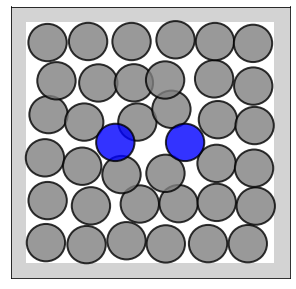

In [482]:
md.draw_config(PredictedConfig[10], dimercolor='blue', alpha=0.8)

In [413]:
md.draw_config(np.array(RealConfig[110]), dimercolor='blue', alpha=0.8)

IndexError: index 110 is out of bounds for dimension 0 with size 20

In [469]:
PredictedConfigEnergy = md.energy(np.array(PredictedConfig.detach()))

In [407]:
b = np.array([1.0,1.2,1.4,1.6,1.8, 2.0])

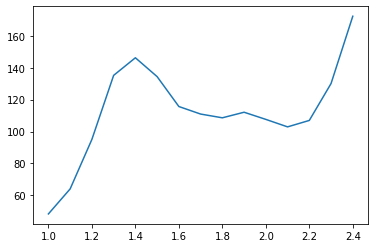

In [485]:
plt.plot(b[:-5],PredictedConfigEnergy[:-5])

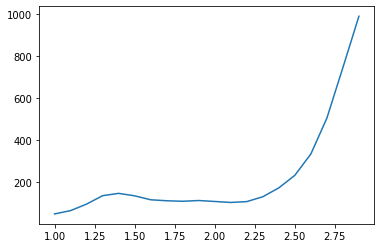

In [484]:
plt.plot(b,PredictedConfigEnergy)

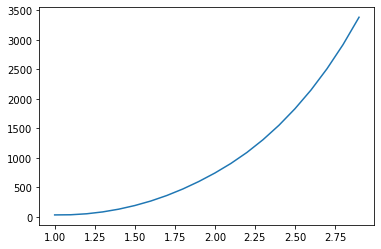

In [431]:
plt.plot(b,PredictedConfigEnergy) #Closed

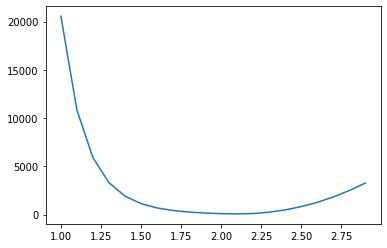

In [461]:
plt.plot(b,PredictedConfigEnergy) #OPen

In [357]:
print ( thresholdFunction(PredictedConfigEnergy, 100.0) )

0


In [358]:
bins = [30,40,50,60,70,80,90,100,200]

(array([0., 1., 1., 2., 1., 1., 0., 0.]),
 array([ 30,  40,  50,  60,  70,  80,  90, 100, 200]),
 <a list of 8 Patch objects>)

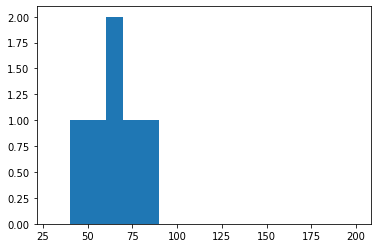

In [359]:
plt.hist(np.array(PredictedConfigEnergy),bins = bins)

In [37]:
energyMc = md.energy(np.array(RealConfig.detach()))
print ( thresholdFunction(energyMc, 100.0) )

0


(array([   0.,  226., 1294.,  433.,   47.,    0.,    0.]),
 array([ 30,  40,  50,  60,  70,  80,  90, 100]),
 <a list of 7 Patch objects>)

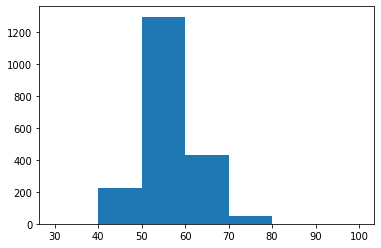

In [38]:
plt.hist(np.array(energyMc),bins = [30,40,50,60,70,80,90,100])